In [1]:
XTC = "CIT-53_PRO1_FIX.xtc"
TPR = "CIT-53_PRO1.tpr"
NAME = XTC[:-8]

import numpy as np
from scipy.spatial.distance import cdist
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from MDAnalysis import *
Z=22
DPI=300

In [2]:
U = Universe(TPR, XTC)
DT = U.trajectory[0].dt

In [3]:
sel = {
"CIT"       : U.select_atoms("resname CIT"),
}

props_mol_area = {
'ref'       : "CIT",
'start_ps'  : 0,
'stop_ps'   : 100000, #100000,
'rotations' : 100, #number of times to rotate the molecule
'samples'   : 1000, #points to calculate the area from
}

In [4]:
radii = {
"C"     : 1.7, #radii in A
"H"     : 1.2,
"O"     : 1.52,
}

In [5]:
def rotation_matrix(abc):
    a = abc[0]
    b = abc[1]
    c = abc[2]
    #return a matrix that rotates a along X, b along Y, and c along Z (in that order)
    Rx = [[1,0,0],[0,np.cos(a), -np.sin(a)],[0, np.sin(a), np.cos(a)]]
    Ry = [[np.cos(b), 0, np.sin(b)],[0,1,0],[-np.sin(b), 0, np.cos(b)]]
    Rz = [[np.cos(c), -np.sin(c),0],[np.sin(c), np.cos(c),0],[0,0,1]]
    Rxyz = np.dot(Rx, np.dot(Ry, Rz))
    return Rxyz

def center(xyz):
    xyz = xyz - np.mean(xyz, axis=0)
    return xyz

def probability_moments(values, frequencies):
    dx = values[1]-values[0]
    expected = np.sum(np.multiply(frequencies*dx, values))
    variance = np.sum(np.multiply(frequencies*dx, values**2)) - expected**2
    variance = np.sqrt(variance)
    return expected, variance

In [6]:
def calc_area(props):
    np.random.seed(666)
    areas = []
    for ts in U.trajectory:
        if ts.time >= props['start_ps'] and ts.time <= props['stop_ps']:
            if ts.time%10000 == 0:
                print(ts.time)
            xyz_ref_or = center(sel[props['ref']].positions)
            for i in range(props['rotations']):
                angles = np.random.rand(3)*2*np.pi
                RT = rotation_matrix(angles)
                xyz_ref = np.dot(RT, xyz_ref_or.T)
                
                xmin, xmax = np.min(xyz_ref[:,0])-2, np.max(xyz_ref[:,0])+2
                ymin, ymax = np.min(xyz_ref[:,1])-2, np.max(xyz_ref[:,1])+2
                vdw = []
                for j in range(len(xyz_ref)):
                    element = sel[props['ref']].atoms[j].name[0]
                    vdw.append(radii[element])

                probes = np.random.rand(props['samples'], 2)
                probes[:,0] = (xmax - xmin) * probes[:,0] + xmin
                probes[:,1] = (ymax - ymin) * probes[:,1] + ymin

                dists = cdist(probes, xyz_ref[:,:2])
                inside = np.sum(np.any(dists<=vdw, axis=1))
                frac = inside/props['samples']
                area = frac*(xmax-xmin)*(ymax-ymin)
                areas.append(area)
    return areas
            
areas = calc_area(props_mol_area)

0.0
10000.0
20000.0
30000.0
40000.0
50000.0
60000.0
70000.0
80000.0
90000.0
100000.0


Area of maximum probability: 0.157 nm2
Expected area: 0.151 +/- 0.016 nm2


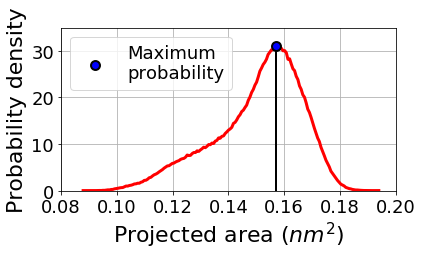

In [18]:
freq, bins = np.histogram(np.array(areas)/100, density=True, bins=180)
bins = (bins[1:]+bins[:-1])/2
moments = probability_moments(bins, freq)
max_area = bins[np.argmax(freq)]
print("Area of maximum probability: {:.3f} nm2".format(max_area))
print("Expected area: {:.3f} +/- {:.3f} nm2".format(*moments))

fig = plt.figure(figsize=(6,3))
ax = plt.axes()
ax.tick_params(labelsize=Z-4)
ax.set_xlabel(r"Projected area ($nm^2$)", fontsize=Z)
ax.set_ylabel("Probability density", fontsize=Z)
ax.grid()
ax.set_xlim(0.08,0.2)
ax.set_ylim(0, 35)
ax.plot(bins, freq, color='r', lw=3)
#ax.axvline(moments[0], ymin=0, ymax=0.68, lw=2, color='k')
#ax.scatter([moments[0]], freq[np.argmin(np.abs(bins-moments[0]))], zorder=10, edgecolor='k', facecolor='b', linewidth=2, s=80, label="Expected value")
ax.scatter([max_area], freq[np.argmin(np.abs(bins-max_area))], zorder=10, edgecolor='k', facecolor='b', linewidth=2, s=80, label="Maximum\nprobability")
ax.axvline(max_area, ymin=0, ymax=0.9, lw=2, color='k')
lgd = ax.legend(fontsize=Z-4, loc='upper left')
plt.savefig("cit_area.png", format='png', dpi=DPI, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [14]:
coverage1, coverage2 = 28*max_area/19.6, 33*max_area/19.6
print(coverage1, coverage2)

0.2246028704002071 0.2647105258288155


In [13]:
print(4*np.pi*1.25**2)

19.634954084936208
